In [9]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf1.Session(config=config)

2023-12-20 11:42:48.524026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4033 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-12-20 11:42:48.526485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4033 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-12-20 11:42:48.528649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 4033 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0
2023-12-20 11:42:48.530811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 4033 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus id

In [158]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from rouge import Rouge
from nltk.tokenize import sent_tokenize

### 전처리

In [159]:
nltk.download('punkt')
nltk.download('stopwords')

# 불용어(stopwords) 목록 로드
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/a202192010/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a202192010/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [235]:
# 뉴스 기사 전처리 함수
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

def preprocess_news_article(news_article):
    # 문장 토큰화
    sentences = sent_tokenize(news_article)

    processed_sentences = []
    for sentence in sentences:
        # 문장 토큰화
        tokens = word_tokenize(sentence)

        # 특수문자 및 숫자 제거
        tokens = [word.lower() for word in tokens if word.isalpha() or word not in string.punctuation]

        # 토큰들을 다시 문장으로 결합
        processed_text = ' '.join(tokens)

        processed_sentences.append(processed_text)

    return processed_sentences


In [236]:
# 예시 뉴스 기사

NEWS_ARTICLE = "The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman and Diu administration a day apart. The circular was withdrawn through a one-line order issued late in the evening by the UT?s department of personnel and administrative reforms.?The circular is ridiculous. There are sensitivities involved. How can the government dictate who I should tie rakhi to? We should maintain the professionalism of a workplace? an official told Hindustan Times earlier in the day. She refused to be identified.The notice was issued on Daman and Diu administrator and former Gujarat home minister Praful Kodabhai Patel?s direction, sources said.Rakshabandhan, a celebration of the bond between brothers and sisters, is one of several Hindu festivities and rituals that are no longer confined of private, family affairs but have become tools to push politic al ideologies.In 2014, the year BJP stormed to power at the Centre, Rashtriya Swayamsevak Sangh (RSS) chief Mohan Bhagwat said the festival had ?national significance? and should be celebrated widely ?to protect Hindu culture and live by the values enshrined in it?. The RSS is the ideological parent of the ruling BJP.Last year, women ministers in the Modi government went to the border areas to celebrate the festival with soldiers. A year before, all cabinet ministers were asked to go to their constituencies for the festival."


In [357]:
# 뉴스 기사 전처리
processed_article = preprocess_news_article(NEWS_ARTICLE)
print("전처리된 기사:", processed_article)

전처리된 기사: ['the daman and diu administration on wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.the union territory s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace', 'it has been decided to celebrate the festival of rakshabandhan on august 7', 'in this connection all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues', 'the order issued on august 1 by gurpreet singh deputy secretary personnel had said.to ensure that no one skipped office an attendance report was to be sent to the government the next evening.the two notifications', 'one mandating the celebration of rakshabandhan left and the other withdrawing the mandate right', 'were issued by th

### BERT

In [238]:
import torch
from transformers import BertTokenizer, BertModel
from nltk.tokenize import sent_tokenize

In [82]:
# BERT 모델 및 토크나이저 로드
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

config.json: 100%|██████████| 570/570 [00:00<00:00, 65.7kB/s]
model.safetensors: 100%|██████████| 440M/440M [00:24<00:00, 18.2MB/s] 
tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 2.82kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 601kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 680kB/s]


In [358]:
# 토크나이저
tokenized_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in processed_article]
tokenized_sentences

[[0,
  627,
  9656,
  260,
  8,
  2269,
  257,
  942,
  15,
  18862,
  46836,
  13666,
  10,
  18629,
  14,
  553,
  390,
  813,
  7,
  3318,
  910,
  7352,
  354,
  15,
  2943,
  4025,
  71,
  5,
  645,
  7544,
  10,
  10279,
  31,
  1321,
  8,
  21,
  12256,
  4102,
  15,
  592,
  433,
  4,
  627,
  2918,
  4284,
  579,
  942,
  21,
  1654,
  7,
  11298,
  624,
  706,
  722,
  9,
  10392,
  5,
  18629,
  14,
  156,
  24,
  25707,
  13,
  63,
  813,
  7,
  3379,
  910,
  677,
  1193,
  31865,
  4134,
  23,
  7637,
  2],
 [0,
  405,
  34,
  57,
  1276,
  7,
  3379,
  5,
  3241,
  9,
  910,
  677,
  1193,
  31865,
  4134,
  15,
  26713,
  4193,
  262,
  2],
 [0,
  179,
  42,
  2748,
  70,
  4088,
  73,
  6522,
  5658,
  1091,
  490,
  8,
  3379,
  5,
  3241,
  14332,
  23,
  10,
  10686,
  86,
  26134,
  70,
  5,
  6429,
  813,
  5658,
  3318,
  910,
  7352,
  354,
  7,
  49,
  4025,
  2],
 [0,
  627,
  645,
  1167,
  15,
  26713,
  4193,
  112,
  30,
  821,
  710,
  642,
  14081,
  788

In [359]:
# 최대 길이 구하기
max_len = 0
for i in tokenized_sentences:
    if len(i) > max_len:
        max_len = len(i)

# 패딩된 문장들
padded_sentences = []
for i in tokenized_sentences:
    # 최대 길이에 도달할 때까지 0으로 패딩
    while len(i) < max_len:
        i.append(0)
    padded_sentences.append(i)

# PyTorch 텐서로 변환
input_ids = torch.tensor(padded_sentences)
input_ids

tensor([[   0,  627, 9656,  ...,    0,    0,    0],
        [   0,  405,   34,  ...,    0,    0,    0],
        [   0,  179,   42,  ...,    0,    0,    0],
        ...,
        [   0,  463,  197,  ...,    0,    0,    0],
        [   0,  627,  910,  ...,    0,    0,    0],
        [   0,  102,   76,  ...,    0,    0,    0]])

In [360]:
input_ids.size()

torch.Size([16, 118])

In [361]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [362]:
vocab_size = bert_model.config.vocab_size # 모델의 vocab_size
vocab_size

30522

In [363]:
vocab_size = 30500
max_index = torch.max(input_ids)

# input_ids 내의 모든 값을 어휘 크기 이하로 제한
input_ids[input_ids > vocab_size] = vocab_size
input_ids

tensor([[   0,  627, 9656,  ...,    0,    0,    0],
        [   0,  405,   34,  ...,    0,    0,    0],
        [   0,  179,   42,  ...,    0,    0,    0],
        ...,
        [   0,  463,  197,  ...,    0,    0,    0],
        [   0,  627,  910,  ...,    0,    0,    0],
        [   0,  102,   76,  ...,    0,    0,    0]])

In [364]:
input_ids.shape

torch.Size([16, 118])

In [365]:
max_index = torch.max(input_ids)
max_index # 최댓값

tensor(30500)

In [366]:
# 모델의 출력
with torch.no_grad():
    all_hidden_states  = bert_model(input_ids)[0]

In [367]:
# 각 문장 임베딩을 평균하여 문장 전체 임베딩 얻기
bert_sentence_embeddings = torch.mean(all_hidden_states, dim=1).numpy()

In [368]:
bert_sentence_embeddings

array([[-0.262925  ,  0.15120715,  0.06920782, ..., -0.49392438,
         0.815937  , -0.02945545],
       [-0.30813193, -0.07224108, -0.14033984, ..., -0.54359436,
         0.8417747 , -0.19259213],
       [-0.15348107,  0.13347183,  0.03283592, ..., -0.5608814 ,
         0.69439113, -0.07183864],
       ...,
       [-0.35193074,  0.05294407, -0.11639063, ..., -0.61349666,
         0.7212711 , -0.14494902],
       [-0.2989488 , -0.06234165, -0.1374794 , ..., -0.52989614,
         0.8737767 , -0.12753004],
       [ 0.21697433,  0.09295134,  1.134148  , ..., -0.46585512,
         0.06917247, -0.9795131 ]], dtype=float32)

In [369]:
bert_sentence_embeddings.shape

(16, 768)

In [370]:
from sklearn.metrics.pairwise import cosine_similarity

In [371]:
# 유사도 행렬 계산
bert_similarity_matrix = cosine_similarity(bert_sentence_embeddings)

In [372]:
bert_similarity_matrix

array([[1.0000002 , 0.92474496, 0.95930505, 0.95105225, 0.9318465 ,
        0.9313162 , 0.9406705 , 0.91699517, 0.9112865 , 0.915306  ,
        0.92282295, 0.91126865, 0.8482593 , 0.9335156 , 0.93422335,
        0.3380583 ],
       [0.92474496, 1.        , 0.97167194, 0.9879476 , 0.9923108 ,
        0.99228585, 0.9898343 , 0.99011457, 0.99239063, 0.992059  ,
        0.9910587 , 0.9920529 , 0.6996031 , 0.98957676, 0.9944438 ,
        0.30990764],
       [0.95930505, 0.97167194, 0.99999964, 0.97645235, 0.9691844 ,
        0.96460795, 0.97028905, 0.95599604, 0.9562422 , 0.9575167 ,
        0.9579422 , 0.9542211 , 0.7961651 , 0.96922976, 0.9707035 ,
        0.34518176],
       [0.95105225, 0.9879476 , 0.97645235, 1.0000001 , 0.9903399 ,
        0.9885352 , 0.99288654, 0.9843228 , 0.98438823, 0.9835757 ,
        0.98628116, 0.9843755 , 0.73644364, 0.9897797 , 0.98864293,
        0.3204363 ],
       [0.9318465 , 0.9923108 , 0.9691844 , 0.9903399 , 1.        ,
        0.99639773, 0.9939338 , 

In [392]:
# 요약 만들기, 유사도
num_sentences = 3
bert_summary_sentences = []
for i in range(num_sentences):
    sentence_scores = list(enumerate(bert_similarity_matrix[i]))
    
bert_sentence_scores = sorted(sentence_scores, key=lambda x: x[1], reverse=True)
bert_sentence_scores

[(2, 0.99999964),
 (3, 0.97645235),
 (1, 0.97167194),
 (14, 0.9707035),
 (6, 0.97028905),
 (13, 0.96922976),
 (4, 0.9691844),
 (5, 0.96460795),
 (0, 0.95930505),
 (10, 0.9579422),
 (9, 0.9575167),
 (8, 0.9562422),
 (7, 0.95599604),
 (11, 0.9542211),
 (12, 0.7961651),
 (15, 0.34518176)]

In [393]:
# 요약문장 표시
bert_summary_sentences.append(processed_article[bert_sentence_scores[1][0]])

bert_summary = ' '.join(bert_summary_sentences)
print(bert_summary)  

the order issued on august 1 by gurpreet singh deputy secretary personnel had said.to ensure that no one skipped office an attendance report was to be sent to the government the next evening.the two notifications


In [394]:
#ROUGE 점수

def calculate_rouge(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    return scores

In [395]:
reference_summary = "The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media."
reference_summary = reference_summary.lower()
reference_summary

'the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august 7. the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [396]:
# ROUGE 점수 계산
bert_rouge_scores = calculate_rouge(bert_summary, reference_summary)
print("ROUGE Scores:", bert_rouge_scores)

ROUGE Scores: [{'rouge-1': {'r': 0.15217391304347827, 'p': 0.21875, 'f': 0.17948717464825786}, 'rouge-2': {'r': 0.017241379310344827, 'p': 0.027777777777777776, 'f': 0.021276591018561483}, 'rouge-l': {'r': 0.15217391304347827, 'p': 0.21875, 'f': 0.17948717464825786}}]


### GPT

In [270]:
from transformers import GPT2Model, GPT2Tokenizer

gpt_model = GPT2Model.from_pretrained('gpt2')
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

config.json: 100%|██████████| 665/665 [00:00<00:00, 56.5kB/s]
model.safetensors: 100%|██████████| 548M/548M [00:17<00:00, 31.0MB/s] 
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 15.6MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 36.7MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 1.68MB/s]


In [273]:
gpt_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwis

In [289]:
vocab_size = gpt_model.config.vocab_size # 모델의 vocab_size
vocab_size

50257

In [290]:
vocab_size = 50257
max_index = torch.max(input_ids)

# input_ids 내의 모든 값을 어휘 크기 이하로 제한
input_ids[input_ids > vocab_size] = vocab_size
input_ids

tensor([[   0,  627, 9656,  ...,    0,    0,    0],
        [   0,  405,   34,  ...,    0,    0,    0],
        [   0,  179,   42,  ...,    0,    0,    0],
        ...,
        [   0,  463,  197,  ...,    0,    0,    0],
        [   0,  627,  910,  ...,    0,    0,    0],
        [   0,  102,   76,  ...,    0,    0,    0]])

In [291]:
input_ids.shape

torch.Size([16, 118])

In [292]:
max_index = torch.max(input_ids)
max_index # 최댓값

tensor(30000)

In [293]:
# 모델의 출력
with torch.no_grad():
    all_hidden_states  = gpt_model(input_ids)[0]

In [297]:
# 각 문장 임베딩을 평균하여 문장 전체 임베딩 얻기
gpt_sentence_embeddings = torch.mean(all_hidden_states, dim=1).numpy()

In [298]:
gpt_sentence_embeddings

array([[ 0.42899892, -0.3247693 ,  0.19022508, ..., -0.3396074 ,
         0.17062797,  0.35829198],
       [-0.13435397, -0.1554592 ,  0.67065907, ..., -0.65106493,
        -0.00858835,  0.60235906],
       [-0.03217074, -0.33315903,  0.65385824, ..., -0.53166044,
         0.22086616,  0.4154809 ],
       ...,
       [-0.11947086, -0.0604829 ,  0.35208467, ..., -0.63463813,
         0.08084037,  0.55952984],
       [ 0.1426142 , -0.16174889,  0.5425769 , ..., -0.5027295 ,
         0.23706818,  0.27046928],
       [ 0.0072054 , -0.4489344 ,  0.5742182 , ..., -0.54602975,
         0.17345917,  0.6082841 ]], dtype=float32)

In [296]:
gpt_sentence_embeddings.shape

(16, 768)

In [283]:
from sklearn.metrics.pairwise import cosine_similarity

In [302]:
# 유사도 행렬 계산
gpt_similarity_matrix = cosine_similarity(gpt_sentence_embeddings)

In [346]:
gpt_similarity_matrix

array([[1.0000001 , 0.8101522 , 0.9614535 , 0.9854795 , 0.7714888 ,
        0.80390155, 0.84275997, 0.7684026 , 0.7296527 , 0.8177986 ,
        0.722939  , 0.7646715 , 0.98207796, 0.7998913 , 0.93664646,
        0.83389467],
       [0.8101522 , 1.0000001 , 0.93407166, 0.8930658 , 0.9978013 ,
        0.99977195, 0.9979865 , 0.9973528 , 0.99130106, 0.99751943,
        0.9901617 , 0.9970695 , 0.8818018 , 0.999612  , 0.9611329 ,
        0.9988039 ],
       [0.9614535 , 0.93407166, 0.9999998 , 0.99305034, 0.91013896,
        0.93054444, 0.951549  , 0.908972  , 0.8842828 , 0.94189644,
        0.87918323, 0.90562713, 0.9761141 , 0.92731196, 0.99556315,
        0.9482267 ],
       [0.9854795 , 0.8930658 , 0.99305034, 0.99999964, 0.86284727,
        0.8883541 , 0.91700935, 0.86101294, 0.8300353 , 0.90055877,
        0.82445186, 0.85749197, 0.98825943, 0.88483906, 0.9809879 ,
        0.911173  ],
       [0.7714888 , 0.9978013 , 0.91013896, 0.86284727, 0.99999964,
        0.9982228 , 0.9921088 , 

In [388]:
# 요약 만들기, 유사도
num_sentences = 3
gpt_summary_sentences = []
for i in range(num_sentences):
    sentence_scores = list(enumerate(gpt_similarity_matrix[i]))
    
gpt_sentence_scores = sorted(sentence_scores, key=lambda x: x[1], reverse=True)
gpt_sentence_scores

[(2, 0.9999998),
 (14, 0.99556315),
 (3, 0.99305034),
 (12, 0.9761141),
 (0, 0.9614535),
 (6, 0.951549),
 (15, 0.9482267),
 (9, 0.94189644),
 (1, 0.93407166),
 (5, 0.93054444),
 (13, 0.92731196),
 (4, 0.91013896),
 (7, 0.908972),
 (11, 0.90562713),
 (8, 0.8842828),
 (10, 0.87918323)]

In [389]:
# 요약문장 표시
gpt_summary_sentences.append(processed_article[gpt_sentence_scores[1][0]])

gpt_summary = ' '.join(gpt_summary_sentences)
print(gpt_summary)  

the rss is the ideological parent of the ruling bjp.last year women ministers in the modi government went to the border areas to celebrate the festival with soldiers


In [390]:
reference_summary = "The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media."
reference_summary = reference_summary.lower()


In [391]:
# ROUGE 점수 계산
gpt_rouge_scores = calculate_rouge(gpt_summary, reference_summary)
print("ROUGE Scores:", gpt_rouge_scores)

ROUGE Scores: [{'rouge-1': {'r': 0.08695652173913043, 'p': 0.17391304347826086, 'f': 0.11594202454106296}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.08695652173913043, 'p': 0.17391304347826086, 'f': 0.11594202454106296}}]


### BERT 결과와 비교

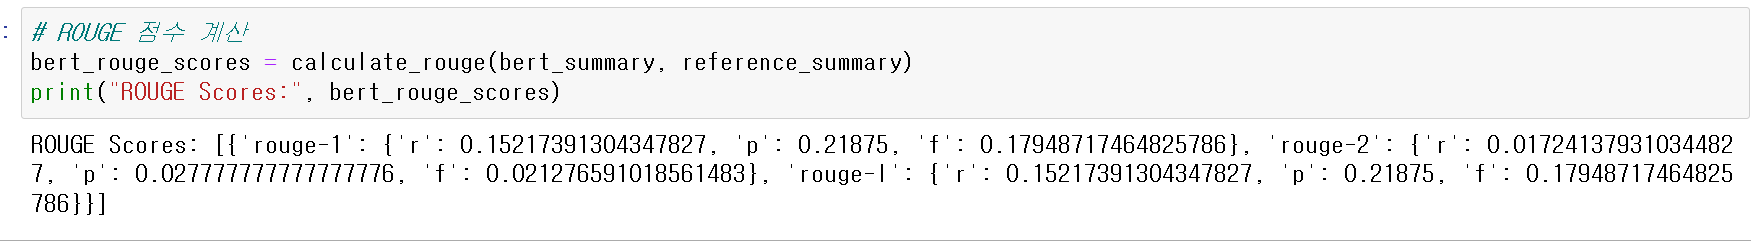